### DISCUSSION POSTING
Similarity Scores. Using the file of data, NBAPlayerStatHistory.xlsx, build your own Similarity Scores metric (or metrics) for players. This has a few options to choose from, including season-by-season individual Four Factors and performance numbers, career basic stats, and career Four Factors numbers. Explain why you chose the approach you did. Choose some comparisons and discuss what you like and dislike about the comparisons.

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin_min
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import matplotlib.cm as cm


In [2]:
# Specify the Excel file path
excel_file_path = '82_nbaplayerstathistory_smww.xlsx'

# Read specific sheets from the Excel file
sheet_names = ['PlayerSeasonDB', 'Career4F_filtered', 'CareerBasics']  # Replace with the actual sheet names

data_frames = {}  # Dictionary to store the data frames for each sheet

header_row = [1, 0, 0]  
for idx, sheet_name in enumerate(sheet_names):
    data_frames[sheet_name] = pd.read_excel(excel_file_path, sheet_name=sheet_name, header=header_row[idx])

# Now you can access the data frames using the sheet names as keys
PlayerSeasonDB = data_frames['PlayerSeasonDB']
Career4F = data_frames['Career4F_filtered']
CareerBasics = data_frames['CareerBasics']

In [3]:
Career4F.head()

,Player,SumOfMin,PositionNumber,htin,mpg,iefffgp,iorebp,idrebp,itovp,iftr,...,iastrate,ifg3r,iblkrate,istlrate,ishotrate,ipfp48,itrebp,ifg2p,ifg3p,ts
0,"Young,Trae",11940.728271,1.0,74.0,33.826426,0.504884,0.021516,0.096531,0.168051,0.362332,...,0.441164,0.384310,0.002298,0.013668,0.311494,2.359655,0.058889,0.491324,0.351072,0.580386
1,"Fox,De'Aaron",12837.458496,1.0,75.0,32.336167,0.510457,0.017585,0.108433,0.138735,0.255109,...,0.301868,0.241379,0.007019,0.019224,0.274409,3.851230,0.062269,0.520412,0.319444,0.553523
2,"Morant,Ja",8051.076660,1.0,75.0,32.076003,0.508435,0.032295,0.125298,0.155518,0.278022,...,0.361368,0.227409,0.004693,0.014784,0.293458,2.313231,0.078643,0.516303,0.321138,0.556848
3,"Mitchell,Donovan",14131.644653,2.0,75.0,33.970300,0.522817,0.026854,0.107179,0.127026,0.208364,...,0.227423,0.406519,0.005006,0.019022,0.322038,3.552877,0.067906,0.504456,0.366415,0.565291
4,"Thompson,David",13304.000000,2.5,76.0,31.156909,0.504600,0.047737,0.076529,0.150420,0.346936,...,0.148114,0.012316,0.013575,0.011664,0.274449,3.791942,0.062262,0.505709,0.277108,0.567223


similarity for Afflalo,Arron


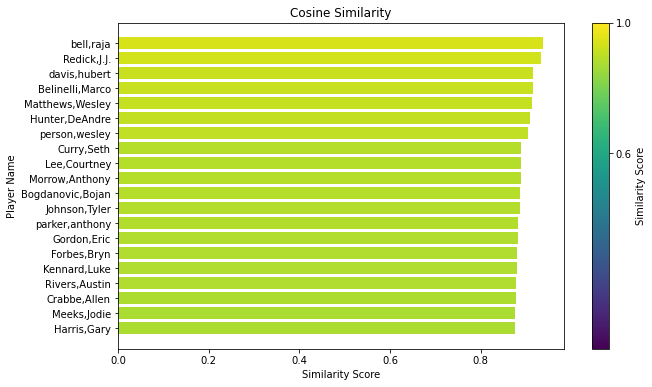

In [84]:
# Drop columns that are not of interest
columns_to_drop = ['Player', 'SumOfMin', 'PositionNumber']
career4f_data = Career4F.drop(columns=columns_to_drop)


career4f_data['ifg2p'].fillna(career4f_data['ifg2p'].mean(), inplace=True)
career4f_data['ifg3p'].fillna(career4f_data['ifg3p'].mean(), inplace=True)


# Normalize the data
scaler = StandardScaler()
normalized_data = scaler.fit_transform(career4f_data)

# Compute cosine similarity between all pairs of players
similarity_matrix = cosine_similarity(normalized_data)

# Select a random player index for demonstration
random_player_index = 614

# Get the similarity scores for the selected player
similarity_scores = similarity_matrix[random_player_index]

print('similarity for ' + Career4F['Player'][random_player_index])

# Create a list of (player_name, similarity_score) tuples
similar_players = [(Career4F['Player'][index], score) for index, score in enumerate(similarity_scores)]

# Sort the similar players by similarity score (higher score means more similar)
similar_players.sort(key=lambda x: x[1], reverse=True)

# Skip the first player (self-similarity)
top_similar_players = similar_players[1:21]  # Select the top 20 similar players

# Extract player names and similarity scores for plotting
player_names = [name for name, _ in top_similar_players]
similarity_scores = [score for _, score in top_similar_players]

# Create a color map using the Viridis color scale
color_map = cm.viridis(similarity_scores)  # Assign colors based on similarity scores

# Create a bar plot of similarity scores with color based on Viridis scale
plt.figure(figsize=(10, 6))
bars = plt.barh(player_names, similarity_scores, color=color_map)
plt.xlabel('Similarity Score')
plt.ylabel('Player Name')
plt.title('Cosine Similarity')
plt.gca().invert_yaxis()  # Invert y-axis to have the highest similarity at the top

# Add color legend
sm = plt.cm.ScalarMappable(cmap=cm.viridis)
sm.set_array([])
cbar = plt.colorbar(sm, orientation='vertical')
cbar.set_ticks([0.6, 1.]) 
cbar.set_label('Similarity Score')

plt.savefig('cosine_similarity.png', dpi=50)

plt.show()

Comparing what Dean Oliver did 

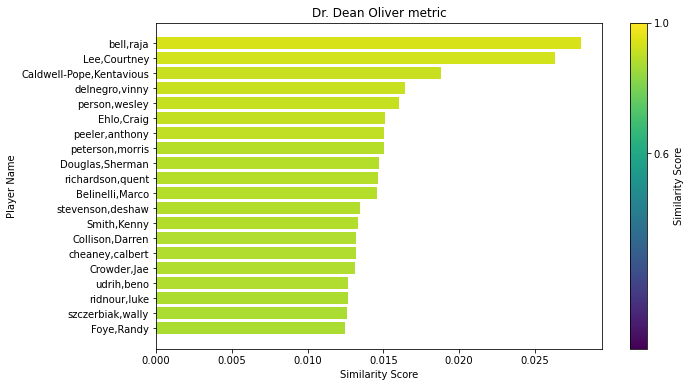

In [85]:
weights = np.array([0.01, 0, 10, 2, 400, 50, 130, 100, 100, 1000, 20, 50, 40, 140, 0, 5, 0, 0, 0, 0])




player_list = list(Career4F['Player'])
player_list.remove(Career4F['Player'][random_player_index])


players_stats = Career4F.iloc[:, 1:].values

players_stats = np.delete(players_stats, random_player_index, axis=0)

similarity_scores = np.zeros((players_stats.shape[0]))
for player in range(players_stats.shape[0]):
    
    difference = np.abs((players_stats[player,:] - random_player_stats)) * weights
    
    for i in range(len(difference)):
        if np.isnan(difference[i]) or np.isinf(difference[i]):
            difference[i] = 0
    
    similarity_scores[player] = np.sum(difference)
    
similarity_scores = np.nan_to_num(similarity_scores, nan=1000)

sorted_indices = np.argsort(similarity_scores)
sorted_similarity_scores = similarity_scores[sorted_indices]

sorted_similarity_scores = 1 / (1 + sorted_similarity_scores)


sorted_player_list = [player_list[i] for i in sorted_indices]


# Create a bar plot of similarity scores with color based on Viridis scale
plt.figure(figsize=(10, 6))
bars = plt.barh(sorted_player_list[:20], sorted_similarity_scores[:20], color=color_map)
plt.xlabel('Similarity Score')
plt.ylabel('Player Name')
plt.title('Dr. Dean Oliver metric')
plt.gca().invert_yaxis()  # Invert y-axis to have the highest similarity at the top

# Add color legend
sm = plt.cm.ScalarMappable(cmap=cm.viridis)
sm.set_array([])
cbar = plt.colorbar(sm, orientation='vertical')
cbar.set_ticks([0.6, 1.]) 
cbar.set_label('Similarity Score')

plt.savefig('Dean.png', dpi=50)

plt.show()

In [131]:
intersection = set(sorted_player_list[:20]).intersection(player_names)
intersection

{'Belinelli,Marco', 'Lee,Courtney', 'bell,raja', 'person,wesley'}

Eucledian Distance

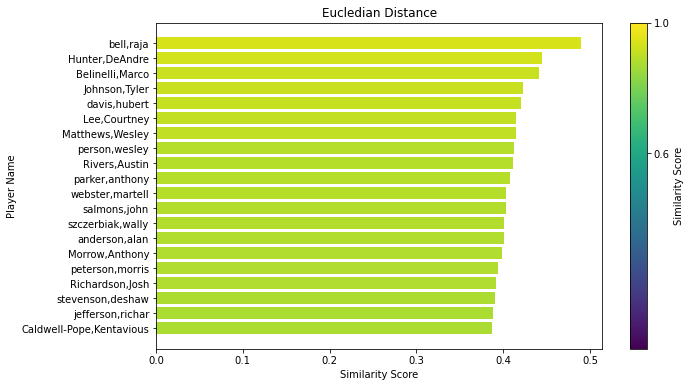

In [86]:
from sklearn.metrics.pairwise import euclidean_distances

# Compute Euclidean distance between all pairs of players
euclidean_distance_matrix = euclidean_distances(normalized_data)

# Get the Euclidean distances for the selected player
euclidean_distances = euclidean_distance_matrix[random_player]

euclidean_distances = np.delete(euclidean_distances, random_player, axis=0)

sorted_indices = np.argsort(euclidean_distances)
sorted_similarity_scores = euclidean_distances[sorted_indices]

sorted_similarity_scores = 1 / (1 + sorted_similarity_scores)

sorted_player_list = [player_list[i] for i in sorted_indices]

# Create a bar plot of similarity scores with color based on Viridis scale
plt.figure(figsize=(10, 6))
bars = plt.barh(sorted_player_list[:20], sorted_similarity_scores[:20], color=color_map)
plt.xlabel('Similarity Score')
plt.ylabel('Player Name')
plt.title('Eucledian Distance')
plt.gca().invert_yaxis()  # Invert y-axis to have the highest similarity at the top

# Add color legend
sm = plt.cm.ScalarMappable(cmap=cm.viridis)
sm.set_array([])
cbar = plt.colorbar(sm, orientation='vertical')
cbar.set_ticks([0.6, 1.]) 
cbar.set_label('Similarity Score')

plt.savefig('euclidian.png', dpi=50)

plt.show()


Pearson Correlation

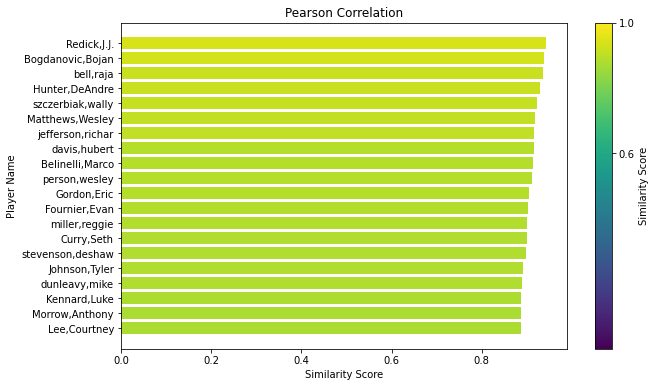

In [87]:
from scipy.stats import pearsonr

# Compute Pearson correlation coefficient between all pairs of players
pearson_correlation_matrix = np.corrcoef(normalized_data)

# Get the Pearson correlation coefficients for the selected player
pearson_correlations = pearson_correlation_matrix[random_player]

pearson_correlations = np.delete(pearson_correlations, random_player, axis=0)


sorted_indices = np.argsort(pearson_correlations)[::-1]
sorted_similarity_scores = pearson_correlations[sorted_indices]


sorted_player_list = [player_list[i] for i in sorted_indices]

# Create a bar plot of similarity scores with color based on Viridis scale
plt.figure(figsize=(10, 6))
bars = plt.barh(sorted_player_list[:20], sorted_similarity_scores[:20], color=color_map)
plt.xlabel('Similarity Score')
plt.ylabel('Player Name')
plt.title('Pearson Correlation')
plt.gca().invert_yaxis()  # Invert y-axis to have the highest similarity at the top

# Add color legend
sm = plt.cm.ScalarMappable(cmap=cm.viridis)
sm.set_array([])
cbar = plt.colorbar(sm, orientation='vertical')
cbar.set_ticks([0.6, 1.]) 
cbar.set_label('Similarity Score')

plt.savefig('correlation.png', dpi=50)

plt.show()

Mahalanobis Distance

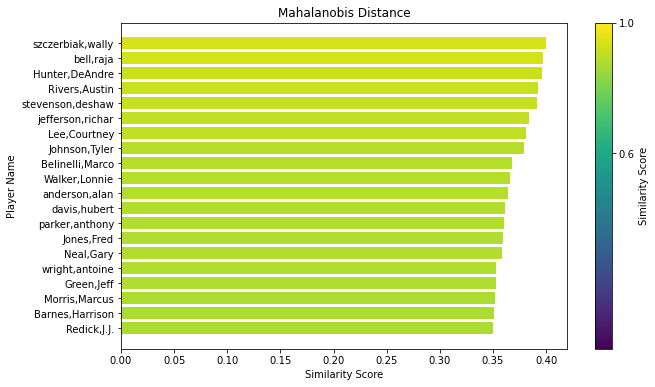

In [88]:
from scipy.spatial import distance


# Compute Mahalanobis distances between the selected player and all other players
mahalanobis_distances = [distance.mahalanobis(normalized_data[random_player], normalized_data[i], np.linalg.inv(np.cov(normalized_data.T))) for i in range(len(normalized_data))]


mahalanobis_distances = np.delete(mahalanobis_distances, random_player, axis=0)

sorted_indices = np.argsort(mahalanobis_distances)
sorted_similarity_scores = mahalanobis_distances[sorted_indices]

sorted_similarity_scores = 1 / (1 + sorted_similarity_scores)

sorted_player_list = [player_list[i] for i in sorted_indices]

# Create a bar plot of similarity scores with color based on Viridis scale
plt.figure(figsize=(10, 6))
bars = plt.barh(sorted_player_list[:20], sorted_similarity_scores[:20], color=color_map)
plt.xlabel('Similarity Score')
plt.ylabel('Player Name')
plt.title('Mahalanobis Distance')
plt.gca().invert_yaxis()  # Invert y-axis to have the highest similarity at the top

# Add color legend
sm = plt.cm.ScalarMappable(cmap=cm.viridis)
sm.set_array([])
cbar = plt.colorbar(sm, orientation='vertical')
cbar.set_ticks([0.6, 1.]) 
cbar.set_label('Similarity Score')

plt.savefig('Mahalanobis.png', dpi=50)

plt.show()


In [98]:
# # Compute Cosine Similarity
columns_to_drop = ['Player', 'SumOfMin', 'PositionNumber']
career4f_data = Career4F.drop(columns=columns_to_drop)
career4f_data['ifg2p'].fillna(career4f_data['ifg2p'].mean(), inplace=True)
career4f_data['ifg3p'].fillna(career4f_data['ifg3p'].mean(), inplace=True)
# Normalize the data
scaler = StandardScaler()
normalized_data = scaler.fit_transform(career4f_data)
# Compute cosine similarity between all pairs of players
similarity_matrix = cosine_similarity(normalized_data)
# Select a random player index for demonstration
random_player_index = 614
# Get the similarity scores for the selected player
similarity_scores = similarity_matrix[random_player_index]
# Create a list of (player_name, similarity_score) tuples
similar_players = [(Career4F['Player'][index], score) for index, score in enumerate(similarity_scores)]
# Sort the similar players by similarity score (higher score means more similar)
similar_players.sort(key=lambda x: x[1], reverse=True)
# Skip the first player (self-similarity)
top_similar_players = similar_players[1:21]  # Select the top 20 similar players
# Extract player names and similarity scores for plotting
cosine_list = [name for name, _ in top_similar_players]



# Compute Dean's metric
weights = np.array([0.01, 0, 10, 2, 400, 50, 130, 100, 100, 1000, 20, 50, 40, 140, 0, 5, 0, 0, 0, 0])
player_list = list(Career4F['Player'])
player_list.remove(Career4F['Player'][random_player_index])
players_stats = Career4F.iloc[:, 1:].values
players_stats = np.delete(players_stats, random_player_index, axis=0)
similarity_scores = np.zeros((players_stats.shape[0]))
for player in range(players_stats.shape[0]):
    
    difference = np.abs((players_stats[player,:] - random_player_stats)) * weights
    
    for i in range(len(difference)):
        if np.isnan(difference[i]) or np.isinf(difference[i]):
            difference[i] = 0
    
    similarity_scores[player] = np.sum(difference)
    
similarity_scores = np.nan_to_num(similarity_scores, nan=1000)
sorted_indices = np.argsort(similarity_scores)
sorted_similarity_scores = similarity_scores[sorted_indices]
sorted_similarity_scores = 1 / (1 + sorted_similarity_scores)
Dean_list = [player_list[i] for i in sorted_indices][:20]




# Compute Euclidean distance between all pairs of players
from sklearn.metrics.pairwise import euclidean_distances
euclidean_distance_matrix = euclidean_distances(normalized_data)
# Get the Euclidean distances for the selected player
euclidean_distances = euclidean_distance_matrix[random_player]
euclidean_distances = np.delete(euclidean_distances, random_player, axis=0)
sorted_indices = np.argsort(euclidean_distances)
sorted_similarity_scores = euclidean_distances[sorted_indices]
sorted_similarity_scores = 1 / (1 + sorted_similarity_scores)
euclidean_distance_list = [player_list[i] for i in sorted_indices][:20]





# Compute Pearson correlation coefficient between all pairs of players
pearson_correlation_matrix = np.corrcoef(normalized_data)
# Get the Pearson correlation coefficients for the selected player
pearson_correlations = pearson_correlation_matrix[random_player]
pearson_correlations = np.delete(pearson_correlations, random_player, axis=0)
sorted_indices = np.argsort(pearson_correlations)[::-1]
sorted_similarity_scores = pearson_correlations[sorted_indices]
pearson_correlation_list = [player_list[i] for i in sorted_indices][:20]


# Compute Mahalanobis distances between the selected player and all other players
mahalanobis_distances = [distance.mahalanobis(normalized_data[random_player], normalized_data[i], np.linalg.inv(np.cov(normalized_data.T))) for i in range(len(normalized_data))]
mahalanobis_distances = np.delete(mahalanobis_distances, random_player, axis=0)
sorted_indices = np.argsort(mahalanobis_distances)
sorted_similarity_scores = mahalanobis_distances[sorted_indices]
sorted_similarity_scores = 1 / (1 + sorted_similarity_scores)
mahalanobis_list = [player_list[i] for i in sorted_indices][:20]

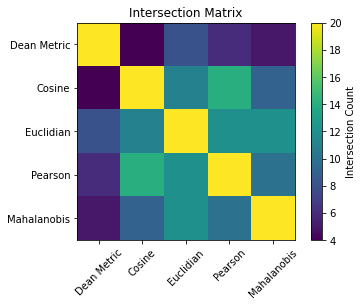

In [117]:
lists = [Dean_list, cosine_list, euclidean_distance_list, pearson_correlation_list, mahalanobis_list]

# Initialize a 5x5 matrix to store intersection counts
matrix = np.zeros((5, 5), dtype=int)

# Compute intersection counts and fill the matrix
for i in range(5):
    for j in range(i, 5):
        intersection_count = len(set(lists[i]).intersection(lists[j]))
        matrix[i][j] = intersection_count
        matrix[j][i] = intersection_count  # Since it's symmetric

# Create a heatmap of the intersection matrix
plt.imshow(matrix, cmap='viridis', interpolation='nearest')
plt.colorbar(label="Intersection Count")
plt.title("Intersection Matrix")
plt.xticks(range(5), ['Dean Metric', 'Cosine', 'Euclidian', 'Pearson', 'Mahalanobis'], rotation=45)  
plt.yticks(range(5), ['Dean Metric', 'Cosine', 'Euclidian', 'Pearson', 'Mahalanobis'])
plt.savefig('correlation.png', dpi=80)

plt.show()

In [118]:
matrix[0,:]

array([20,  4,  8,  6,  5])

Text(0.5, 1.0, '"Scree plot" of singular values')

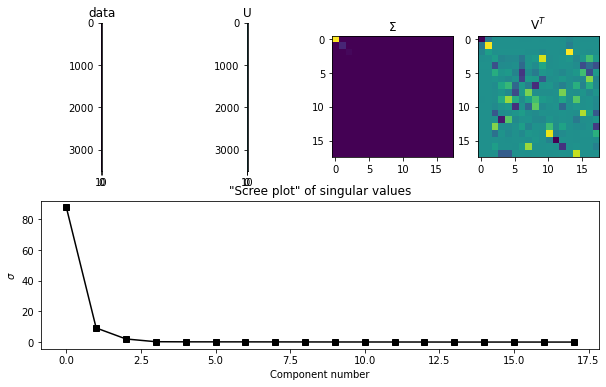

In [29]:
#U,S,V = np.linalg.svd(career4f_data)
U, S, V = np.linalg.svd(career4f_data, full_matrices=False)

S_PC = (100*S)/(np.sum(S))


# show the constituent matrices
fig = plt.subplots(1,figsize=(10,6))

plt.subplot(241)
plt.imshow(career4f_data)
plt.title('data')

plt.subplot(242)
plt.imshow(U)
plt.title('U')

plt.subplot(243)
plt.imshow(np.diag(S))
plt.title('$\Sigma$')

plt.subplot(244)
plt.imshow(V)
plt.title('V$^T$')

S_PC = (100*S)/(np.sum(S))

plt.subplot(212)
plt.plot(S_PC,'ks-')
plt.xlabel('Component number')
plt.ylabel('$\sigma$')
plt.title('"Scree plot" of singular values')

Top Similar Players:
Player: robertson,ryan, Similarity Score: 0.0538
Player: Robinson,Truck, Similarity Score: 0.0493
Player: Brown,Jabari, Similarity Score: 0.0459
Player: Lockhart,Darrell, Similarity Score: 0.0459
Player: Martin,Brian, Similarity Score: 0.0458
Player: holcomb,randy, Similarity Score: 0.0455
Player: Kispert,Corey, Similarity Score: 0.0455
Player: houston,allan, Similarity Score: 0.0450
Player: Hunter,DeAndre, Similarity Score: 0.0450
Player: Bogdanovic,Bojan, Similarity Score: 0.0449
Player: stojakovic,peja, Similarity Score: 0.0444
Player: miller,reggie, Similarity Score: 0.0441
Player: Barnes,Harrison, Similarity Score: 0.0430
Player: bowen,bruce, Similarity Score: 0.0428
Player: Thompson,Klay, Similarity Score: 0.0428
Player: elliott,sean, Similarity Score: 0.0428
Player: bell,raja, Similarity Score: 0.0427
Player: Robinson,Duncan, Similarity Score: 0.0426
Player: Shamet,Landry, Similarity Score: 0.0424
Player: Afflalo,Arron, Similarity Score: 0.0424


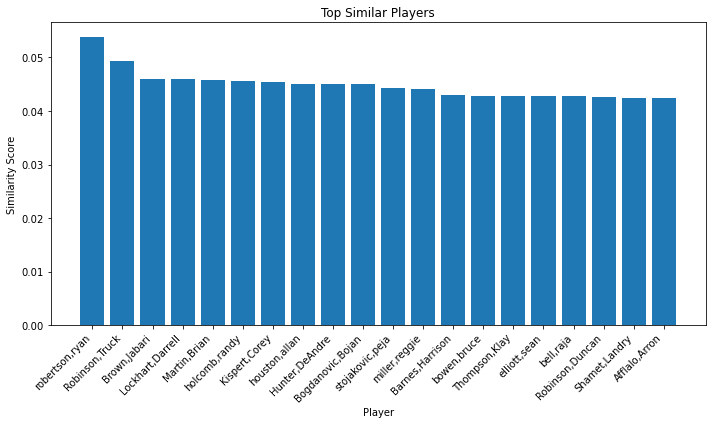

In [31]:
# Select a player index for demonstration
modes = 0
# Select a player index for demonstration
selected_player_index = 614

# Extract the selected player's latent feature scores
selected_player_scores = U[selected_player_index, :]

# Calculate the similarity scores between players
similarity_scores = np.dot(U, selected_player_scores)

# Normalize the similarity scores
similarity_scores = similarity_scores / np.linalg.norm(similarity_scores)

# Create a list of (player_name, similarity_score) tuples
similar_players = [(data_frames['Career4F_filtered']['Player'][index], score) for index, score in enumerate(similarity_scores)]

# Sort the similar players by similarity score (higher score means more similar)
similar_players.sort(key=lambda x: x[1], reverse=True)


# Print the most similar players
print("Top Similar Players:")
for player, score in similar_players[:20]:
    print(f"Player: {player}, Similarity Score: {score:.4f}")

# Visualize the similarity scores
plt.figure(figsize=(10, 6))
plt.bar([player for player, _ in similar_players[:20]], [score for _, score in similar_players[:20]])
plt.xticks(rotation=45, ha="right")
plt.xlabel("Player")
plt.ylabel("Similarity Score")
plt.title("Top Similar Players")
plt.tight_layout()
plt.show()
    


In [14]:
similar_players[-20:]

[('webb,spud', 0.014822738486044313),
 ('garner,chris', 0.014809752560361255),
 ('Howard,Markus', 0.014807069120496407),
 ('wilks,mike', 0.014774930650569323),
 ('Kimbrough,Stan', 0.014761409978171285),
 ('Harper,Jared', 0.014758586655833463),
 ('whiteside,donald', 0.014744862277525911),
 ('Jackson,Pierre', 0.014742251177569582),
 ('Johnson,Carldell', 0.014695570447584275),
 ('Collins,Sherron', 0.014655451435304806),
 ('Felder,Kahlil', 0.014552528713505973),
 ('Pressey,Phil', 0.014535297127605902),
 ('Clemons,Chris', 0.014525473782575396),
 ('Jennings,Keith', 0.014514118956230296),
 ('Nathan,Howard', 0.014507440638183093),
 ('barrett,andre', 0.014469928864135092),
 ('tabuse,yuta', 0.01430847507881069),
 ('Grant,Greg', 0.014267063495676517),
 ('boykins,earl', 0.014174238268300303),
 ('Bogues,Muggsy', 0.014155594488192261)]

                  Player    Similarity
0           {Young,Trae}  1.000000e+00
768        {Higgins,Rod}  6.765422e-17
496        {Adebayo,Bam}  5.898060e-17
407        {Bantom,Mike}  5.551115e-17
3     {Mitchell,Donovan}  5.507747e-17
...                  ...           ...
1223       {Smith,Jason} -7.285839e-17
873        {jones,james} -7.285839e-17
7        {Sexton,Collin} -9.714451e-17
670     {ellis,laphonso} -9.887924e-17
1         {Fox,De'Aaron} -1.604619e-16

[3503 rows x 2 columns]
